In [69]:
%matplotlib inline
import pickle
import matplotlib.pyplot as plt
import numpy as np
import PIL

# load pretrained network
with open('network/trained_network.pkl', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    net = u.load()

In [70]:
# make prediction on input feature vector x
def predict(x):
    print('Network output: \n' + str(np.round(net.feedforward(x), 2)) + '\n')
    print('Network prediction: ' + str(np.argmax(net.feedforward(x))) + '\n')
    print('Actual image: ')
    plt.imshow(x.reshape((28,28)), cmap='Greys')
    return net.feedforward(x), 

Network output: 
[[0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]

Network prediction: 2

Actual image: 


(array([[6.38700252e-12],
        [3.39579628e-11],
        [9.99998661e-01],
        [5.07599318e-10],
        [6.85370891e-10],
        [4.24091104e-12],
        [8.11725314e-05],
        [2.28532444e-03],
        [7.94447581e-16],
        [1.47759728e-13]]),)

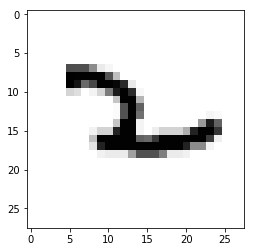

In [61]:
x = np.asarray(PIL.Image.open('/Users/zetong/mnist_png/testing/2/1722.png'))
img = PIL.Image.fromarray(x, mode='L')
x = x.reshape(28,28)
x = x.reshape(784, 1)
x = x.astype('float32')
x /= 255
predict(x)

In [71]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))
                                                                                                                                                                                
def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))

In [63]:
def input_derivative(net, x, y):
    """ Calculate derivatives wrt the inputs"""
    nabla_b = [np.zeros(b.shape) for b in net.biases]
    nabla_w = [np.zeros(w.shape) for w in net.weights]
    
    # feedforward
    activation = x
    activations = [x] # list to store all the activations, layer by layer
    zs = [] # list to store all the z vectors, layer by layer
    for b, w in zip(net.biases, net.weights):
        z = np.dot(w, activation)+b
        zs.append(z)
        activation = sigmoid(z)
        activations.append(activation)
        
    # backward pass
    delta = net.cost_derivative(activations[-1], y) * \
        sigmoid_prime(zs[-1])
    nabla_b[-1] = delta
    nabla_w[-1] = np.dot(delta, activations[-2].transpose())

    for l in range(2, net.num_layers):
        z = zs[-l]
        sp = sigmoid_prime(z)
        delta = np.dot(net.weights[-l+1].transpose(), delta) * sp
        nabla_b[-l] = delta
        nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        
    # Return derivatives WRT to input
    return net.weights[0].T.dot(delta)

In [72]:
# net: neural network object, n: target label, x_target: x feature vector, steps: gradient descent steps,
# eta: step size, lam: regularization constant
def create_adversarial(net, n, x_target, steps, eta, lam=.05):    
    # Set the one-hot target output
    goal = np.zeros((10, 1))
    goal[n] = 1
    
    # gradient descent starting point
    x = np.random.normal(.5, .3, (784, 1))

    # Gradient descent on the input
    for i in range(steps):
        # derivative
        d = input_derivative(net,x,goal)
        # gradient update
        x -= eta * (d + lam * (x - x_target))

    return x

In [67]:
x = np.asarray(PIL.Image.open('/Users/zetong/mnist_png/testing/7/64.png'))
img = PIL.Image.fromarray(x, mode='L')
x = x.reshape(28,28)
x = x.reshape(784, 1)
x = x.astype('float32')
x /= 255
adversarial = create_adversarial(net, 3, x, 10000, 1)

Network output: 
[[0.  ]
 [0.  ]
 [0.  ]
 [0.98]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.02]
 [0.  ]
 [0.  ]]

Network prediction: 3

Actual image: 


(array([[1.79855217e-07],
        [2.09300066e-10],
        [3.45349897e-03],
        [9.82841271e-01],
        [5.76938465e-11],
        [1.84067375e-12],
        [6.31939686e-08],
        [1.61218722e-02],
        [8.97753762e-16],
        [5.36694609e-08]]),)

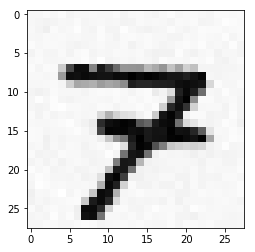

In [68]:
predict(adversarial)